# PointNet Implementation

## Data Transformation: STL to Point Clouds

In [1]:
from src.STLToPointClouds.StlToPointClouds import AeroDynamicsPointCloudDataset, STLToPointCloudConverter

In [2]:
def test_pointcloud_conversion():
    """Test point cloud conversion on sample vehicles"""
    print("Testing STL → Point Cloud conversion...")
    
    # Test with small dataset
    dataset = AeroDynamicsPointCloudDataset(subset_size=2, num_points=2048)
    
    print(f"\nTesting {len(dataset)} vehicles:")
    
    for i in range(len(dataset)):
        point_cloud, drag_coeff = dataset[i]
        
        print(f"\nVehicle {i+1}:")
        print(f"  Point cloud shape: {point_cloud.shape}")  # Should be (6, 1024)
        print(f"  Drag coefficient: {drag_coeff:.4f}")
        
        # Check data ranges
        points = point_cloud[:3, :].numpy()  # xyz coordinates
        normals = point_cloud[3:, :].numpy()  # surface normals
        
        print(f"  Points range: X[{points[0].min():.2f}, {points[0].max():.2f}], "
              f"Y[{points[1].min():.2f}, {points[1].max():.2f}], "
              f"Z[{points[2].min():.2f}, {points[2].max():.2f}]")
        
        print(f"  Normals range: [{normals.min():.2f}, {normals.max():.2f}]")
        
        # Visualize first vehicle
        if i == 0:
            converter = STLToPointCloudConverter(num_points=1024)
            # Transpose back for visualization: (1024, 6)
            converter.visualize_pointcloud(point_cloud.T.numpy(), 
                                         f"Vehicle {i+1} (Cd={drag_coeff:.4f})")


# def analyze_pointcloud_dataset():
#     """Analyze point cloud conversion across all vehicles"""
#     print("Analyzing point cloud conversion across all 484 vehicles...")
    
#     dataset = AeroDynamicsPointCloudDataset(num_points=2048)
    
#     successful_conversions = 0
#     failed_conversions = 0
#     point_ranges = []
    
#     for i in range(len(dataset)):
#         point_cloud, drag_coeff = dataset[i]
        
#         # Check if conversion was successful (not all zeros)
#         if point_cloud.sum() == 0:
#             failed_conversions += 1
#         else:
#             successful_conversions += 1
            
#             # Collect point coordinate ranges
#             points = point_cloud[:3, :].numpy()
#             ranges = {
#                 'x_range': points[0].max() - points[0].min(),
#                 'y_range': points[1].max() - points[1].min(), 
#                 'z_range': points[2].max() - points[2].min()
#             }
#             point_ranges.append(ranges)
        
#         if i % 50 == 0:
#             print(f"Processed {i+1}/{len(dataset)} vehicles...")
    
#     print(f"\nPoint Cloud Analysis:")
#     print(f"  Successful conversions: {successful_conversions}/{len(dataset)}")
#     print(f"  Failed conversions: {failed_conversions}")
    
#     if point_ranges:
#         ranges_df = pd.DataFrame(point_ranges)
#         print(f"  Vehicle size statistics:")
#         print(f"    X range: {ranges_df['x_range'].mean():.2f} ± {ranges_df['x_range'].std():.2f}")
#         print(f"    Y range: {ranges_df['y_range'].mean():.2f} ± {ranges_df['y_range'].std():.2f}")
#         print(f"    Z range: {ranges_df['z_range'].mean():.2f} ± {ranges_df['z_range'].std():.2f}")


# def compare_pointcloud_vs_voxels():
#     """Compare point cloud vs voxel representations"""
#     print("Comparing Point Cloud vs Voxel representations...")
    
#     # Load same vehicle with both methods
#     from src.Voxelization.voxelize import STLToVoxelConverter
    
#     stl_path = "data/drivaerml_data/run_1/drivaer_1.stl"
    
#     # Point cloud conversion
#     pc_converter = STLToPointCloudConverter(num_points=2048)
#     point_cloud, pc_success = pc_converter.convert_stl_to_pointcloud(stl_path)
    
#     # Voxel conversion
#     voxel_converter = STLToVoxelConverter(grid_size=32)
#     voxels, voxel_success = voxel_converter.convert_stl_to_voxels(stl_path)
    
#     print(f"\nComparison for drivaer_1.stl:")
#     print(f"  Point cloud: {point_cloud.shape} = {point_cloud.size} values")
#     print(f"  Voxels: {voxels.shape} = {voxels.size} values")
#     print(f"  Compression ratio: {voxels.size / point_cloud.size:.1f}x")
    
#     print(f"\nData characteristics:")
#     print(f"  Point cloud non-zero: {np.count_nonzero(point_cloud)} / {point_cloud.size}")
#     print(f"  Voxels non-zero: {np.count_nonzero(voxels)} / {voxels.size}")
    
#     # Visualize both
#     if pc_success:
#         pc_converter.visualize_pointcloud(point_cloud, "Point Cloud Representation")
    
#     if voxel_success:
#         voxel_converter.visualize_voxels(voxels, "Voxel Representation")



Testing STL → Point Cloud conversion...
Dataset loaded: 2 vehicles
Point cloud size: 2048 points × 6 features (xyz + normals)

Testing 2 vehicles:

Vehicle 1:
  Point cloud shape: torch.Size([6, 2048])
  Drag coefficient: 0.3000
  Points range: X[0.58, 1.65], Y[-0.77, 0.77], Z[0.67, 1.16]
  Normals range: [-0.97, 0.99]


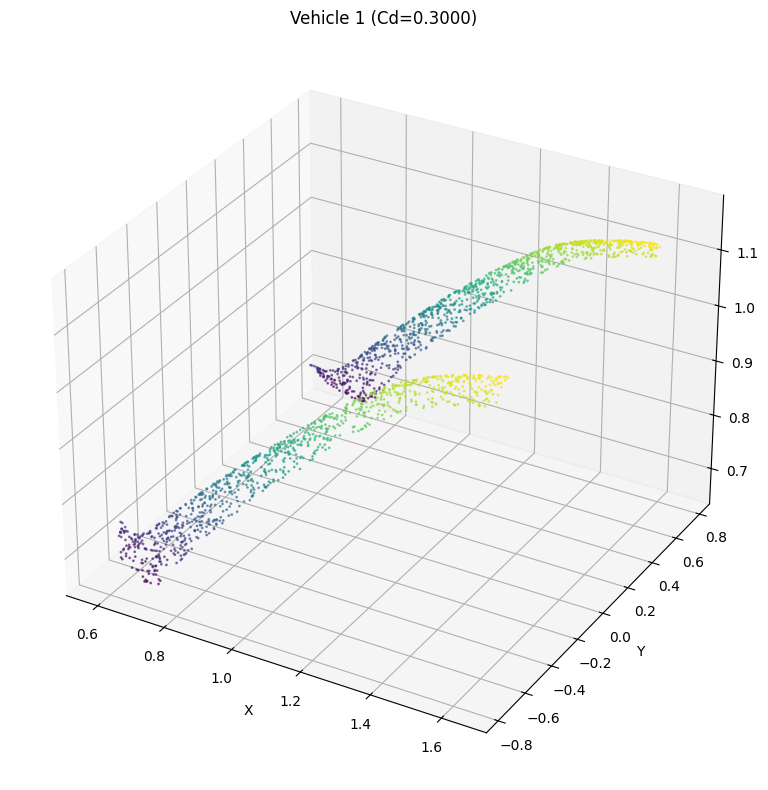


Vehicle 2:
  Point cloud shape: torch.Size([6, 2048])
  Drag coefficient: 0.2800
  Points range: X[0.57, 1.47], Y[-0.85, 0.85], Z[0.56, 1.01]
  Normals range: [-0.90, 1.00]


In [3]:
test_pointcloud_conversion()

## PointNet

In [ ]:
from torch.utils.data import DataLoader
import torch
from src.PointNet.PointNet import AeroDynamicPointNet, PointNetTrainer

In [10]:
def create_pointnet_dataloaders(dataset, batch_size=16, val_split=0.25):
    """Create train/validation dataloaders"""
    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    split = int(val_split * dataset_size)
    
    np.random.shuffle(indices)
    train_indices, val_indices = indices[split:], indices[:split]
    
    train_dataset = torch.utils.data.Subset(dataset, train_indices)
    val_dataset = torch.utils.data.Subset(dataset, val_indices)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    
    print(f"Dataset split: {len(train_dataset)} train, {len(val_dataset)} validation")
    return train_loader, val_loader


In [11]:
def run_pointnet_experiment(num_points=2048, batch_size=16, epochs=50):
    """Run complete PointNet experiment"""
    
    print(f"=== PointNet Experiment ===")
    print(f"Points per car: {num_points}")
    print(f"Batch size: {batch_size}")
    print(f"Epochs: {epochs}")
    
    # Load dataset
    from src.STLToPointClouds.StlToPointClouds import AeroDynamicsPointCloudDataset
    dataset = AeroDynamicsPointCloudDataset(num_points=num_points)
    
    # Create dataloaders
    train_loader, val_loader = create_pointnet_dataloaders(dataset, batch_size)
    
    # Create model
    model = AeroDynamicPointNet(feature_transform=True)
    
    # Train
    trainer = PointNetTrainer(model, train_loader, val_loader)
    best_r2 = trainer.train(epochs)
    
    # Results
    baseline_r2 = 0.879
    improvement = best_r2 - baseline_r2
    
    print(f"\n=== Results ===")
    print(f"Best PointNet R²: {best_r2:.2f}")
    print(f"Baseline R²: {baseline_r2:.2f}")
    print(f"Improvement: {improvement:+.2f} ({improvement/baseline_r2*100:+.1f}%)")
    
    if best_r2 > 0.90:
        print("🎉 SUCCESS: >90% R² achieved!")
    elif best_r2 > baseline_r2:
        print("✅ IMPROVEMENT: Beat baseline!")
    else:
        print("⚠️  Below baseline - needs optimization")
    
    trainer.plot_training_curves()
    return model, trainer, best_r2

=== PointNet Experiment ===
Points per car: 2048
Batch size: 16
Epochs: 3
Dataset loaded: 484 vehicles
Point cloud size: 2048 points × 6 features (xyz + normals)
Dataset split: 363 train, 121 validation
Training PointNet on cuda
Model parameters: 247,370

Epoch 1/3


Validation: 100%|██████████| 8/8 [03:44<00:00, 28.00s/it, Val Loss=0.003021] 


Train Loss: 0.192790, Val Loss: 0.002476, Val R²: -7.24

Epoch 2/3


Validation: 100%|██████████| 8/8 [03:10<00:00, 23.82s/it, Val Loss=0.017817] 


Train Loss: 0.170688, Val Loss: 0.019249, Val R²: -64.18

Epoch 3/3


Validation: 100%|██████████| 8/8 [03:11<00:00, 23.97s/it, Val Loss=0.021408] 


Train Loss: 0.151787, Val Loss: 0.013876, Val R²: -44.32

=== Results ===
Best PointNet R²: -7.24
Baseline R²: 0.88
Improvement: -8.12 (-923.9%)
⚠️  Below baseline - needs optimization


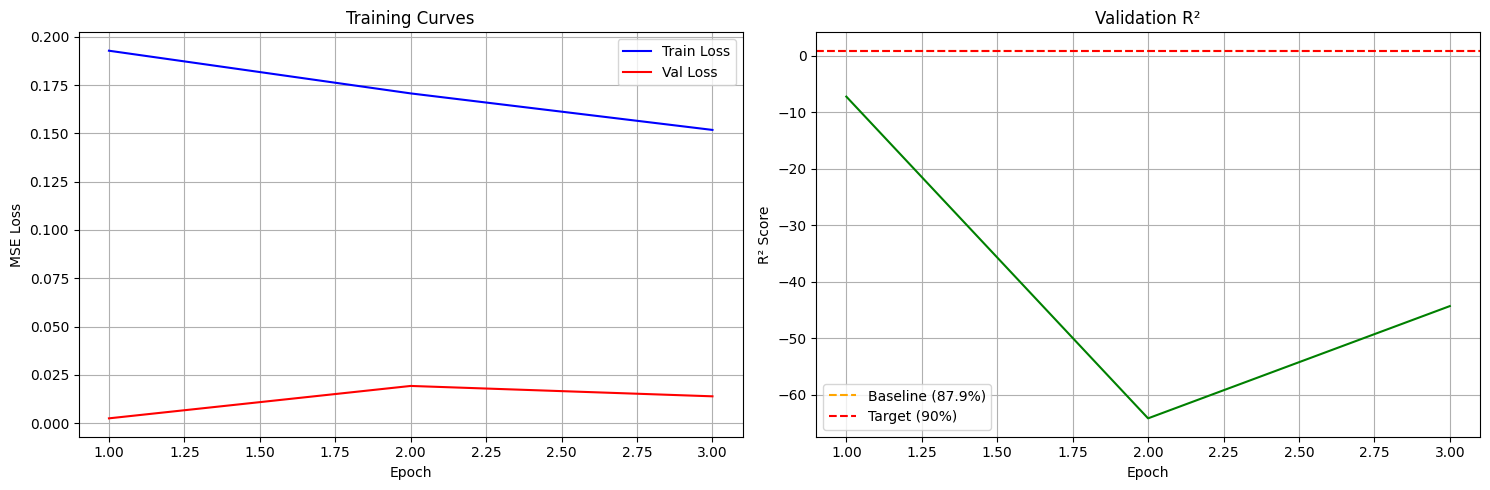

In [12]:
model, trainer, best_r2 = run_pointnet_experiment(num_points=2048,
                                                  batch_size=16,
                                                  epochs=3)